In [1]:
%load_ext autoreload
%autoreload 2

# 1. Load libraries

In [2]:
import os
os.chdir('../')

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

/Users/gbemidebe/miniconda3/envs/ActiveLearn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# unravel append numpy
def unraveled(preds):
    return np.concatenate(preds).ravel()

In [5]:
# fix random seed
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.enabled = False

In [6]:
from src.query import RandomSampling, LeastConfidence, MarginSampling, EntropySampling, \
                             LeastConfidenceDropout, MarginSamplingDropout, EntropySamplingDropout, \
                             KMeansSampling, KCenterGreedy, BALDDropout, \
                             AdversarialBIM, AdversarialDeepFool
from src.preprocessing import Handler, Data
from src.network import Net, Regressor

# 2. Load Data

In [7]:
data = pd.read_excel('./data/sr01/am4c01401_si_001.xlsx')
data.drop(columns=['Ref.'], inplace=True)
data.head()

,Protein Adsorption (ng/cm2),Mn,Density,Thickness,Sub_Ad,pH,Temp,Pro_Conc,Ionic strength,Flow rate,Pol_Type,Mpro,Charge
0,1800.0,12000,0.74,11.04,3350.0,7.4,37,1.00,150,0.0,5.8,66000,-2.4
1,3100.0,12000,0.14,2.15,3350.0,7.4,37,1.00,150,0.0,5.8,66000,-2.4
2,220.0,12200,0.10,1.50,410.0,7.4,23,0.05,150,0.0,9.4,340000,-1.6
3,160.0,12200,0.14,2.00,410.0,7.4,23,0.05,150,0.0,9.4,340000,-1.6
4,50.0,12200,0.29,4.40,410.0,7.4,23,0.05,150,0.0,9.4,340000,-1.6


In [8]:
data.dtypes

Protein Adsorption (ng/cm2)    float64
Mn                               int64
Density                        float64
Thickness                      float64
Sub_Ad                         float64
pH                             float64
Temp                             int64
Pro_Conc                       float64
Ionic strength                   int64
Flow rate                      float64
Pol_Type                       float64
Mpro                             int64
Charge                         float64
dtype: object

In [9]:
features_col = data.columns[1:]
target_col = data.columns[0]
print('Features: ', features_col)
print('Target: ', target_col)

Features:  Index(['Mn', 'Density', 'Thickness', 'Sub_Ad', 'pH', 'Temp', 'Pro_Conc',
       'Ionic strength', 'Flow rate', 'Pol_Type', 'Mpro', 'Charge'],
      dtype='object')
Target:  Protein Adsorption (ng/cm2)


Text(0, 0.5, 'Frequency')

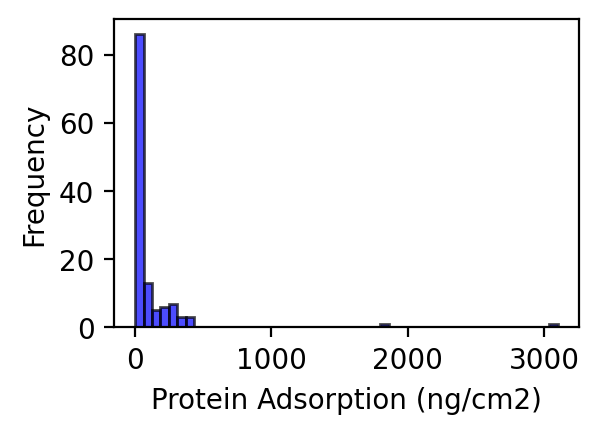

In [10]:
# data description
plt.figure(figsize=(3, 2), dpi=200)
# histogram using matplotlib
k = plt.hist(data[target_col], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel(target_col)
plt.ylabel('Frequency')

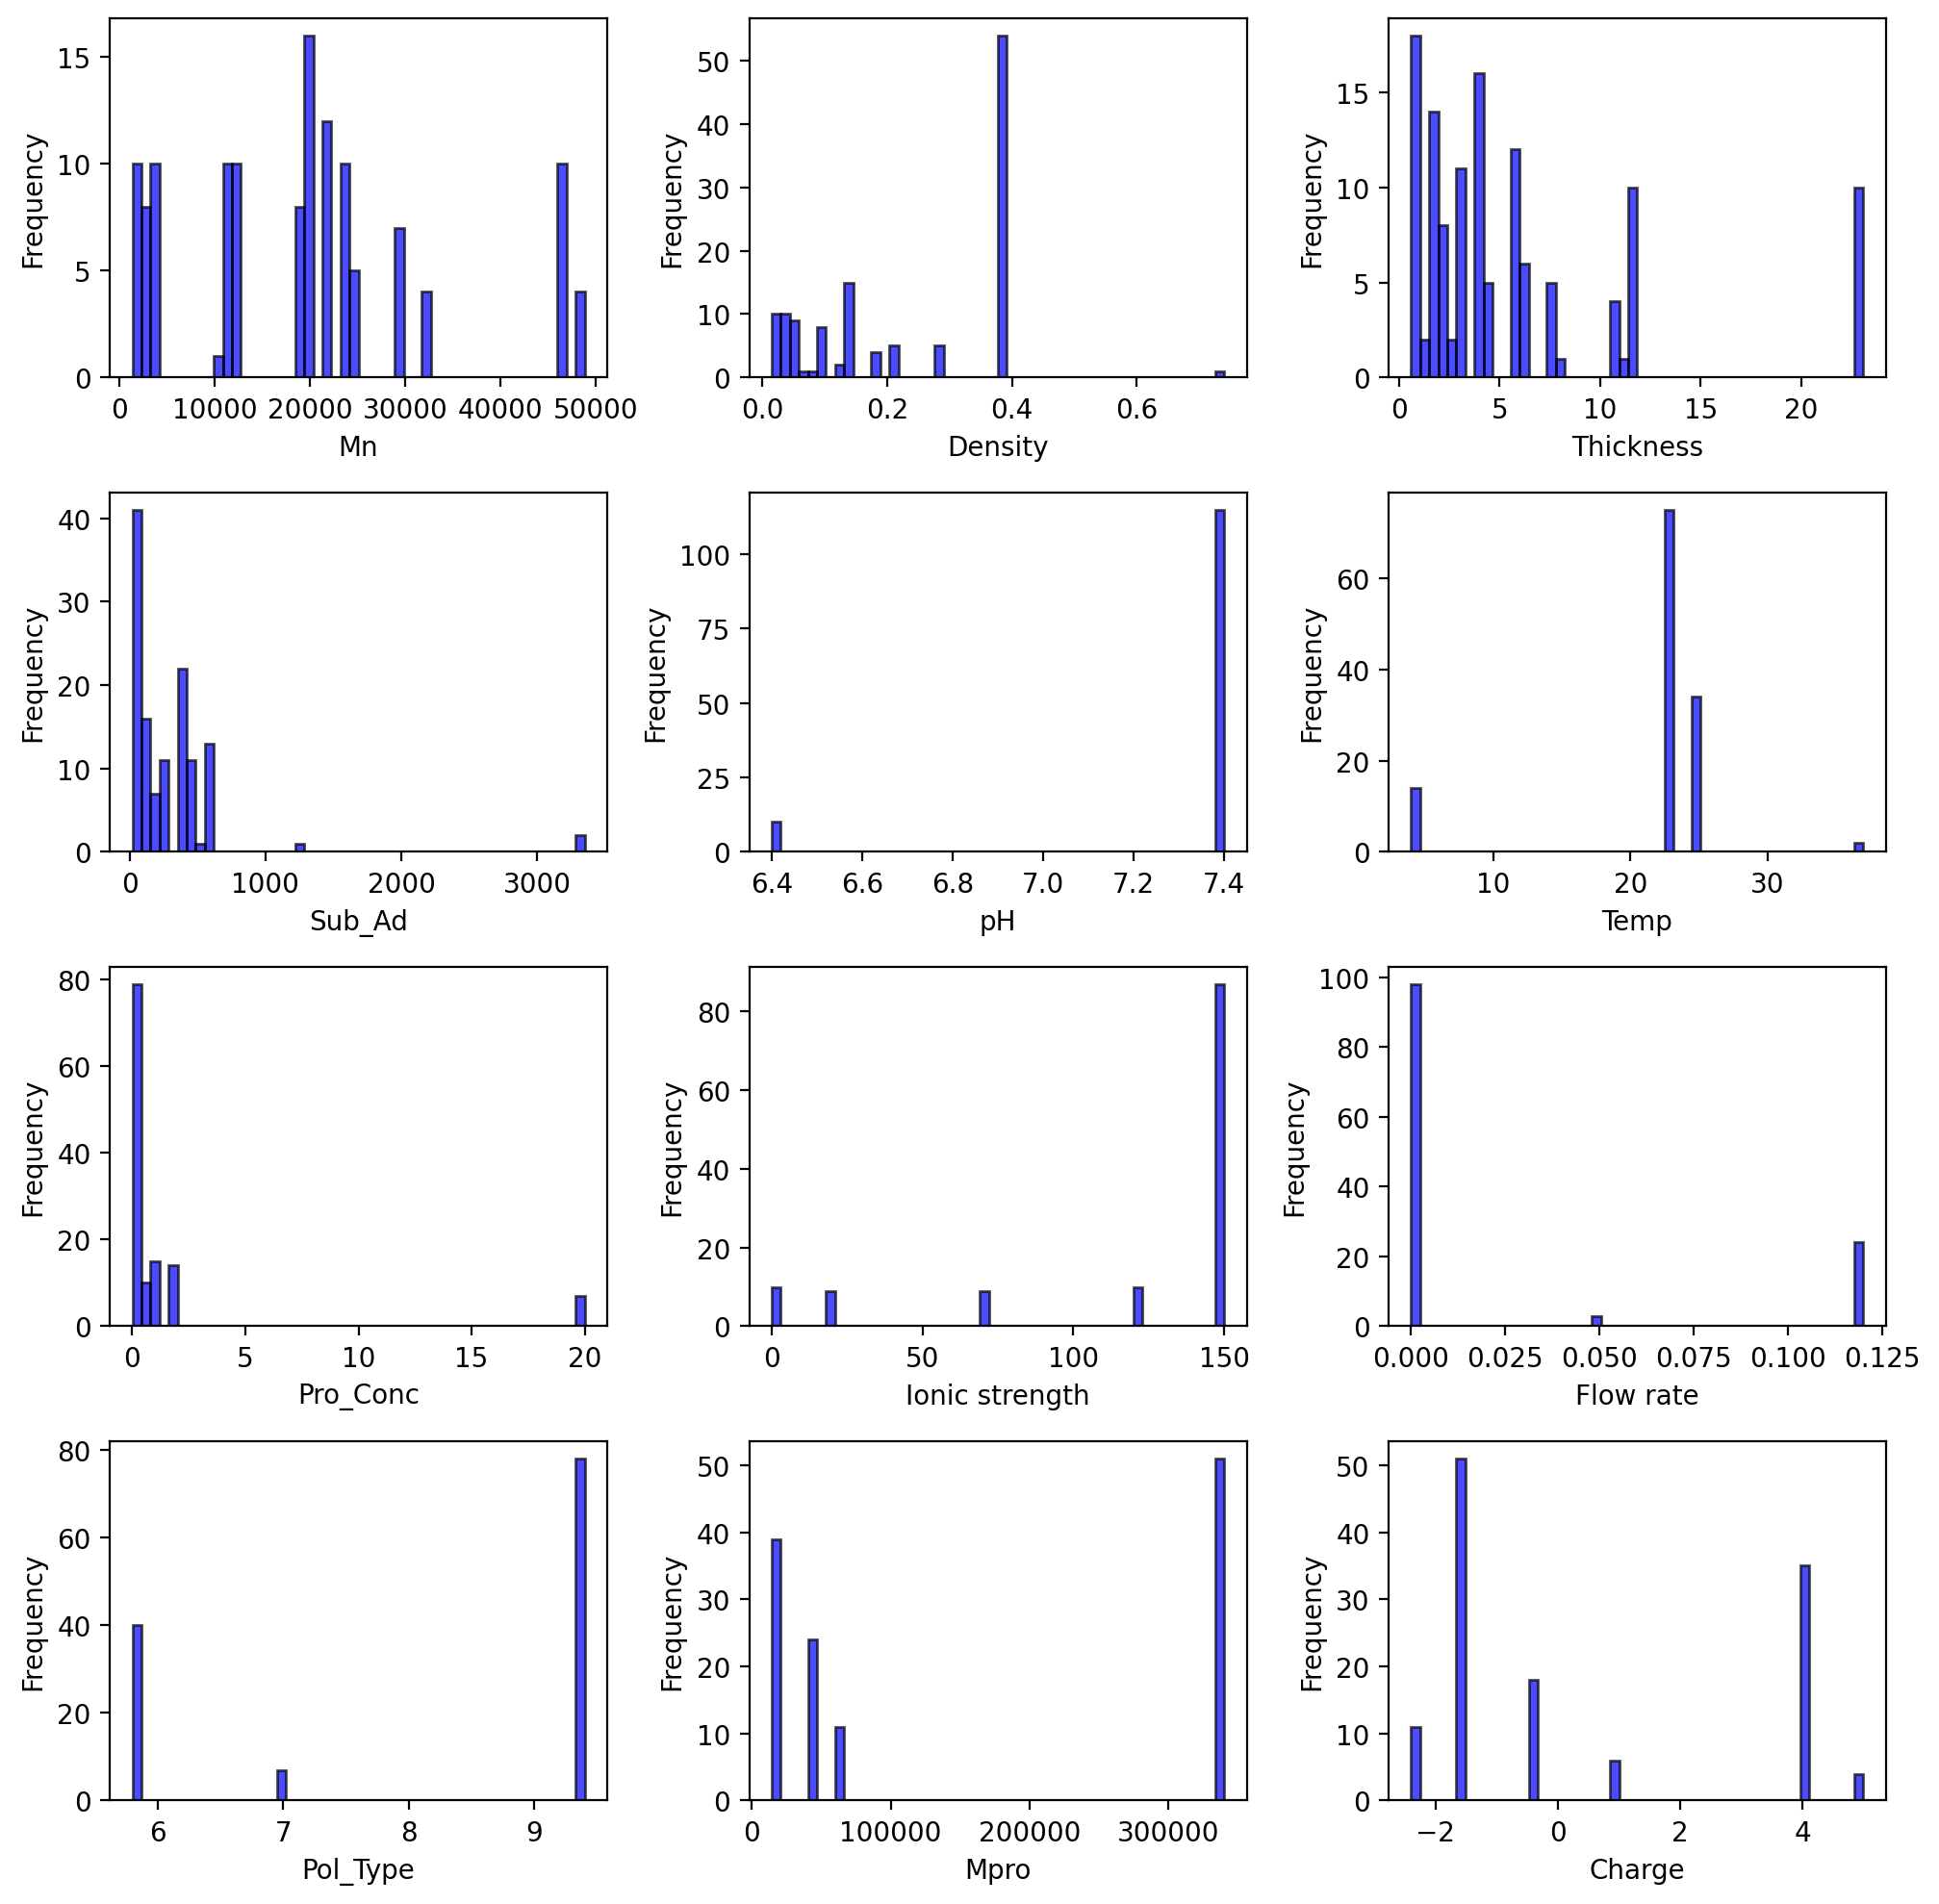

In [11]:
# show histogram for all features with subplots
plt.figure(figsize=(10, 10), dpi=200)
for i, feature in enumerate(features_col):
    plt.subplot(4, 3, i+1)
    k = plt.hist(data[feature], bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()

# 3. Model Training

In [12]:
dataset = Data(data, features_col, target_col, test_size=0.2, random_state=42, handler=Handler)

Scaling the data
Splitting the data


In [13]:
# params
params =  {'n_epoch': 100, 
               'train':{'batch_size': 32},
               'test':{'batch_size': 32},
               'optim':{'lr': 0.001, 'amsgrad': False}}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net =  Net(net=Regressor(input_dim=len(features_col), n_hidden_size=32),
           params=params, device=device)
           
print(net)

In [14]:
# the strategy to query the data
strategy = RandomSampling(dataset, net)  # load strategy

In [15]:
# start experiment
n_init_labeled = 10
dataset.initialize_labels(n_init_labeled)
print(f"number of labeled pool: {n_init_labeled}")
print(f"number of unlabeled pool: {dataset.n_pool - n_init_labeled}")
print(f"number of testing pool: {dataset.n_test}")
print()

number of labeled pool: 10
number of unlabeled pool: 90
number of testing pool: 25



In [16]:
# first training
strategy.train()

100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2297.05it/s]


In [17]:

print("Round 0")
n_round = 100
n_query = 10
strategy.train()
preds = strategy.predict(dataset.get_test_data())
#print(f"Round 0 testing accuracy: {dataset.cal_test_acc(preds)}")
print(f'Round 0 testing R2: {r2_score(unraveled(preds[1]), unraveled(preds[0]))}')

for rd in range(1, n_round+1):
    print(f"Round {rd}")

    # query
    query_idxs = strategy.query(n_query)
    print(f"Queried indexes: {query_idxs}")

    # update labels
    strategy.update(query_idxs)
    strategy.train()

    # calculate accuracy
    preds = strategy.predict(dataset.get_test_data())
    print(f"Round {rd} testing accuracy: {dataset.cal_test_acc(np.concatenate(preds[0]).ravel())}")

Round 0


  0%|                                                                       | 0/100 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2018.41it/s]


Round 0 testing R2: 0.033839870652837556
Round 1
Queried indexes: [39 31 69 36 24 80 99 20  7 91]


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2891.33it/s]


Round 1 testing accuracy: -0.0020327206452115387
Round 2
Queried indexes: [30 40 62 86 17 74 67 54 18 58]


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2511.94it/s]


Round 2 testing accuracy: -0.009853025421915351
Round 3
Queried indexes: [27 92 49 97 15 61 75 13 55 16]


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1572.80it/s]


Round 3 testing accuracy: -0.026042675565953743
Round 4
Queried indexes: [21 94 22 60 79 66 59 64 57 73]


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 283.20it/s]


Round 4 testing accuracy: 0.550870848529595
Round 5
Queried indexes: [29 42 78 45 48  1 11 44 25 51]


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 918.47it/s]


Round 5 testing accuracy: 0.9522021319610375
Round 6
Queried indexes: [76 65 12 90 95 34 41 85 98 71]


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 963.97it/s]


Round 6 testing accuracy: 0.9773488624525011
Round 7
Queried indexes: [89  2 96 68 53 19 87 14 93 32]


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1069.92it/s]


Round 7 testing accuracy: 0.9717398227697334
Round 8
Queried indexes: [56 88  9 46 35 52 84 10 26 83]


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 958.62it/s]


Round 8 testing accuracy: 0.9784113726887849
Round 9
Queried indexes: [ 6 38  3 47 77 33 72 43 37 23]


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 865.00it/s]


Round 9 testing accuracy: 0.9876472455152722
Round 10


ValueError: 'a' cannot be empty unless no samples are taken